### A.  Importing Libraries

In [ ]:
pip install openml

In [1]:
import openml
import pandas as pd
import numpy as np
from openml.datasets import edit_dataset, fork_dataset, get_dataset

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

### B.    Loading Dataset

In [2]:
# Data Loading From OpenML using Dataset ID
# Look at Data Description here: https://www.openml.org/search?type=data&status=active&id=45548
def openml_load(id):
    dataset = openml.datasets.get_dataset(
        id, 
        download_data=True,
        download_qualities=True,
        download_features_meta_data=True
    )
    df, *_  = dataset.get_data()
    return df, df.shape

# Loading Data and initial preprocessing
df_otto, _ = openml_load(45548)
df_otto['target'] = df_otto['target'].map(lambda x: int(x.split('_')[1])) # Converting String Target Values to Integer Labels from 1 to 9
# Step 1: Split into 50,000 training datasets and the rest as testing datasets
X = df_otto.drop('target', axis=1)
y = df_otto['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=50000, random_state=23, stratify=y)

print("\n\n", X_train.shape, X_test.shape, y_train.shape, y_test.shape)




 (50000, 93) (11878, 93) (50000,) (11878,)


### C. Exploratory Data Analysis

NOTE: We have a sparse dataset which is fine because each product does not have every feature.

In [3]:
# FUNCTIONS FOR ANALYSIS: WITHOUT CHANGING THE DATA

# Step 1: Basic Exploration
def basic_exploration(df):
    print("Shape of the dataset:")
    print(df.shape)
    print("\nData types of columns:")
    print(df.dtypes)
    print("\nMissing values:")
    print(sum(df.isnull().sum()))
    num_zeros = (df == 0).sum().sum()
    total_elements = df.size
    sparsity = (num_zeros / total_elements) * 100
    print("\nSparsity:")
    print(sparsity)

# Step 2: Class Distribution
def class_distribution(df):
    class_counts = df.value_counts()
    print("\nClass Distribution:")
    print(class_counts)
    plt.figure(figsize=(8, 6))
    sns.countplot(x='target', data=pd.DataFrame(df))
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

# Step 3: Correlation Analysis with Target
def correlation_analysis_with_target(df, target_column):

    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in the DataFrame.")

    numerical_features = df.select_dtypes(include=np.number).columns
    numerical_features = numerical_features[numerical_features != target_column]

    correlations = {}
    for column in numerical_features:
        correlation = df[column].corr(df[target_column])
        correlations[column] = correlation

    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    plt.figure(figsize=(4, 20))
    sns.heatmap(df[numerical_features].corrwith(df[target_column]).to_frame(),
                annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f'Correlation with {target_column}')
    plt.show()

Shape of the dataset:
(50000, 93)

Data types of columns:
feat_1     uint8
feat_2     uint8
feat_3     uint8
feat_4     uint8
feat_5     uint8
           ...  
feat_89    uint8
feat_90    uint8
feat_91    uint8
feat_92    uint8
feat_93    uint8
Length: 93, dtype: object

Missing values:
0

Sparsity:
79.31120430107526

Class Distribution:
2    13027
6    11422
8     6839
3     6468
9     4004
7     2294
5     2213
4     2174
1     1559
Name: target, dtype: int64


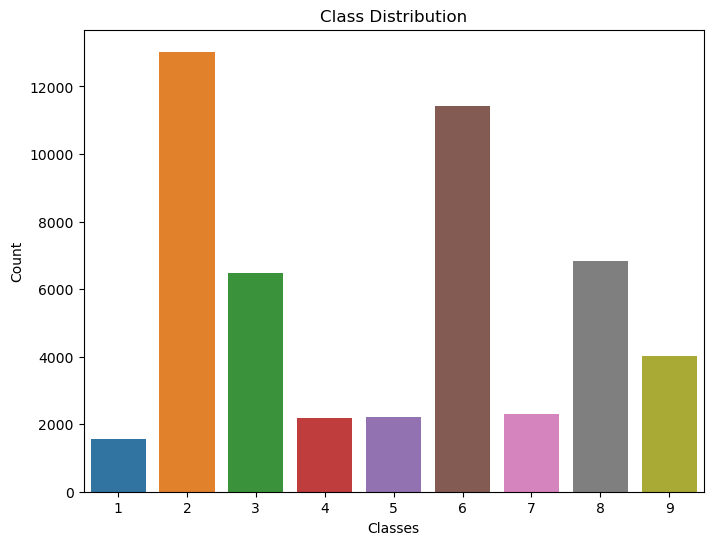

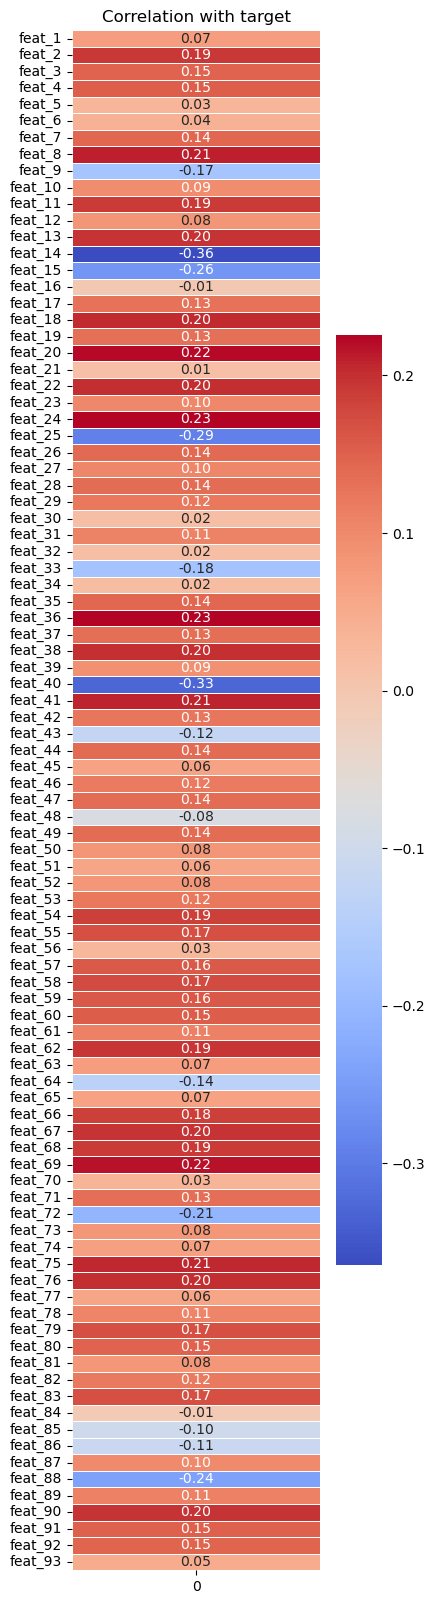

In [4]:
#1
basic_exploration(X_train)
#2
class_distribution(y_train)
#3
correlation_analysis_with_target(pd.concat([X_train, y_train], axis=1), 'target')

Principal Component Analysis: Also helping us in taking care of sparcity

In [5]:
# PREPROCESSING FUNCTIONS: EFFECT DATA

# Step 4: Data Scaling and PCA
def data_preprocessing_with_PCA(x_train, x_test, y_train, retain_variation = 0.90):

    # NOTE: Use fit_transform on training data, and then transform on test data. Don't change target column.
    scaler         = MaxAbsScaler()
    X_train_scaled = scaler.fit_transform(x_train)
    X_test_scaled  = scaler.transform(x_test)

    pca = PCA(n_components=retain_variation)  # Retain retain_variation% of the variance
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='Set1', legend='full')
    plt.title('Example PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    return X_train_pca, X_test_pca

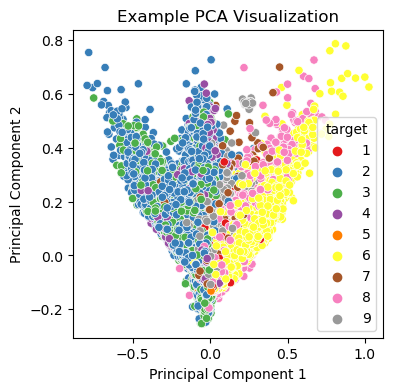

In [6]:
X_train_pca, X_test_pca = data_preprocessing_with_PCA(X_train, X_test, y_train, retain_variation = 0.95)

Exporting dataset as Pickle file

In [7]:
import pickle
# Dumping data into a pickle file
with open('train_test_data.pkl', 'wb') as f:
    pickle.dump((X_train_pca, X_test_pca, y_train, y_test), f)

#### **Handling Target Class Distribution**

**NOTE**: Class balancing is not required for all the methods. It is always better to implement with and without scaling. Then try out different scaling methods given below(not necessarily all) to observe changes in your methods. Avoide using `SMOTE` without reading its documentation.



Class Disctribution Before Balancing


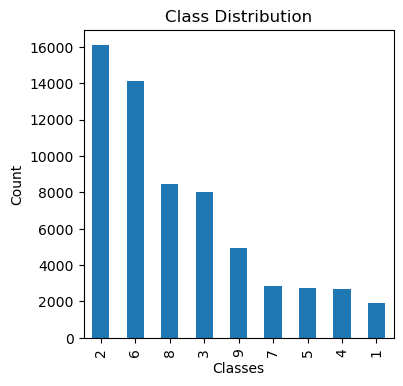



Class Distribution After SMOTE


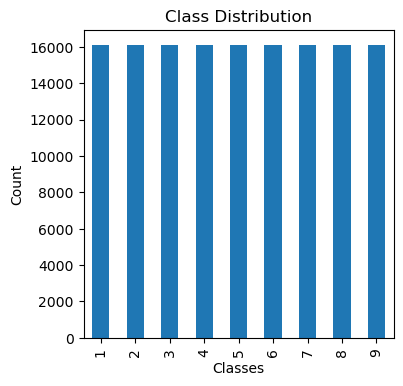



Class Distribution After random_over_sampling


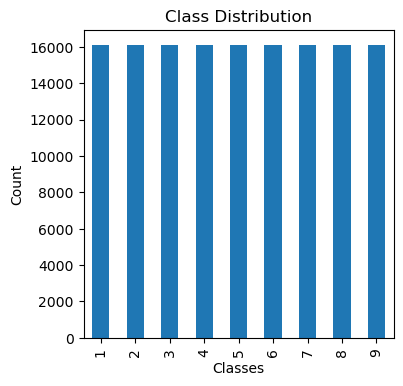



Class Distribution After random_under_sampling


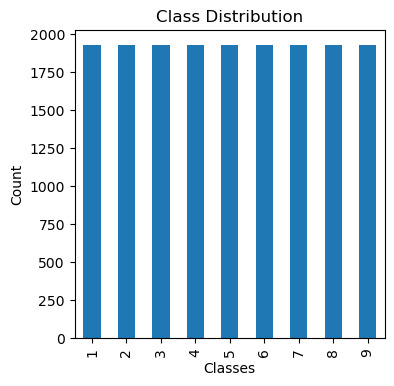



Class Distribution After adasyn


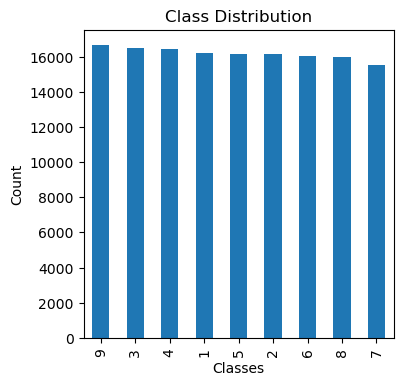



Class Distribution After nearmiss


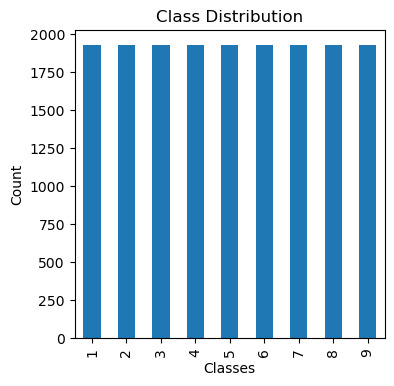

0

In [8]:
def class_dist_plot(data):
    class_distribution = data['target'].value_counts()
    # Plotting the class distribution
    plt.figure(figsize=(4, 4))
    class_distribution.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()
    return 0

def balance_classes(df, target_column, method='random_over_sampling', **kwargs):
    """
    Balances the class distribution of a DataFrame by generating more examples of the minority class(es) only.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        target_column (str): The name of the target column containing class labels.
        method (str): The resampling method to use. Options:
                      - 'random_over_sampling': Random over-sampling of the minority class.
                      - 'smote': Synthetic Minority Over-sampling Technique (SMOTE).
                      - 'adasyn': Adaptive Synthetic Sampling (ADASYN).
                      - 'random_under_sampling': Random under-sampling of the majority class.
                      - 'nearmiss': NearMiss algorithm for under-sampling.
        **kwargs: Additional keyword arguments specific to the chosen resampling method.

    Returns:
        DataFrame: The DataFrame with balanced class distribution.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]

    if method == 'random_over_sampling':
        sampler = RandomOverSampler(**kwargs)
    elif method == 'smote':
        sampler = SMOTE(**kwargs)
    elif method == 'adasyn':
        sampler = ADASYN(**kwargs)
    elif method == 'random_under_sampling':
        sampler = RandomUnderSampler(**kwargs)
    elif method == 'nearmiss':
        sampler = NearMiss(**kwargs)
    else:
        raise ValueError("Invalid resampling method. Please choose from: 'random_over_sampling', 'smote', 'adasyn', "
                         "'random_under_sampling', 'nearmiss' ")

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    resampled_df = pd.concat([X_resampled, pd.DataFrame({target_column: y_resampled})], axis=1)

    return resampled_df

# Before Balancing
print("\n\nClass Disctribution Before Balancing")
class_dist_plot(df_otto)

#==================== Few Class Balancing Options ================================

# After Balancing with SMOTE
print("\n\nClass Distribution After SMOTE")
balanced_df = balance_classes(df_otto, 'target', method='smote', random_state=42)
class_dist_plot(balanced_df)

# After Balancing with random_over_sampling
print("\n\nClass Distribution After random_over_sampling")
balanced_df = balance_classes(df_otto, 'target', method='random_over_sampling', random_state=42)
class_dist_plot(balanced_df)

# After Balancing with random_under_sampling
print("\n\nClass Distribution After random_under_sampling")
balanced_df = balance_classes(df_otto, 'target', method='random_under_sampling', random_state=42)
class_dist_plot(balanced_df)

# After Balancing with adasyn
print("\n\nClass Distribution After adasyn")
balanced_df = balance_classes(df_otto, 'target', method='adasyn', random_state=42)
class_dist_plot(balanced_df)

# After Balancing with nearmiss
print("\n\nClass Distribution After nearmiss")
balanced_df = balance_classes(df_otto, 'target', method='nearmiss')
class_dist_plot(balanced_df)

# Start Working From Here.

In [9]:
# IMPORTING DATASET

with open('train_test_data.pkl', 'rb') as f:
    (X_train_pca, X_test_pca, y_train, y_test) = pickle.load(f)

X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape

((50000, 63), (11878, 63), (50000,), (11878,))

### KNN Model

In [13]:
"""
Choosing the best K

"""

# Importing Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Create Range of K values
k_values = range(1, 21)  # Try K values from 1 to 20

# Empty list to store cross-validation scores
cv_scores = []

for k in k_values:
    # Create KNN model with K value
    knn_model = KNeighborsClassifier(n_neighbors=k)

    # Perform 10-fold cross-validation
    scores = cross_val_score(knn_model, X_train_pca, y_train, cv=10)

    # Mean cross-validation score
    mean_score = np.mean(scores)

    # Add mean score to list of cross-validation scores
    cv_scores.append(mean_score)

# Find the K value with the highest cross-validation score
best_k = k_values[np.argmax(cv_scores)]
best_score = cv_scores[np.argmax(cv_scores)]

print("Best K value:", best_k)
print("Best cross-validation score:", best_score)

Best K value: 9
Best cross-validation score: 0.75966


Best K value: 9
Best cross-validation score: 0.75966


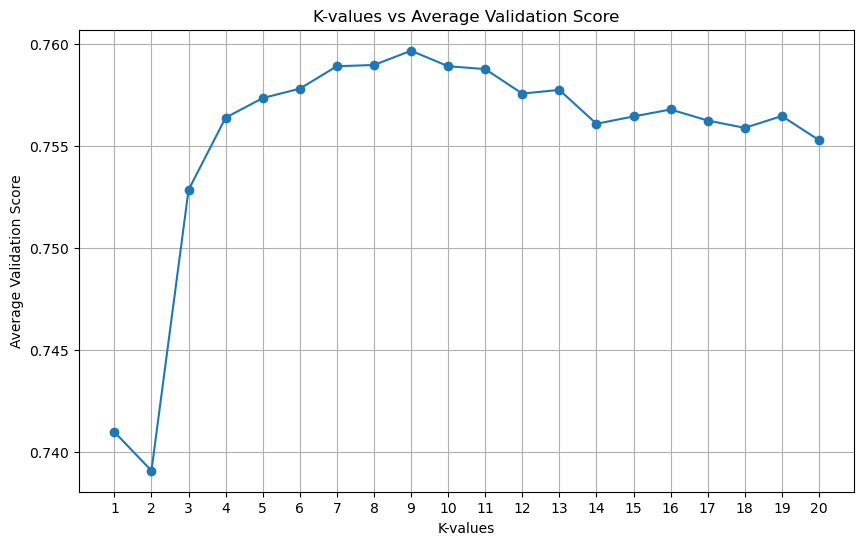

In [14]:
import matplotlib.pyplot as plt

# Find the K value with the highest cross-validation score
best_k_value = k_values[np.argmax(cv_scores)]
best_score = cv_scores[np.argmax(cv_scores)]

print("Best K value:", best_k_value)
print("Best cross-validation score:", best_score)

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-')
plt.title('K-values vs Average Validation Score')
plt.xlabel('K-values')
plt.ylabel('Average Validation Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [15]:
"""
Create and fit KNN model

"""

# Import necessary libraries
from sklearn.metrics import accuracy_score

# Define the number of neighbors (K)
k = 9  # Best K value

# Create KNN model
knn_model = KNeighborsClassifier(n_neighbors=k)

# Fit the model on training data
knn_model.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = knn_model.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of KNN model:", accuracy)

Accuracy of KNN model: 0.7624179154739855


### SVM Model

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Define SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42)

# Train the classifier
svm_classifier.fit(X_train_pca, y_train)

# Make predictions
y_pred_train = svm_classifier.predict(X_train_pca)
y_pred_test = svm_classifier.predict(X_test_pca)

# Evaluate the classifier
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Classification report
print("\nClassification Report for Train Data:")
print(classification_report(y_train, y_pred_train))

print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_pred_test))

Train Accuracy: 0.79842
Test Accuracy: 0.7756356288937531

Classification Report for Train Data:
              precision    recall  f1-score   support

           1       0.74      0.49      0.59      1559
           2       0.66      0.93      0.77     13027
           3       0.67      0.32      0.43      6468
           4       0.91      0.33      0.49      2174
           5       0.97      0.95      0.96      2213
           6       0.95      0.95      0.95     11422
           7       0.80      0.65      0.72      2294
           8       0.88      0.93      0.90      6839
           9       0.85      0.87      0.86      4004

    accuracy                           0.80     50000
   macro avg       0.82      0.71      0.74     50000
weighted avg       0.81      0.80      0.78     50000


Classification Report for Test Data:
              precision    recall  f1-score   support

           1       0.64      0.41      0.50       370
           2       0.65      0.91      0.76      30

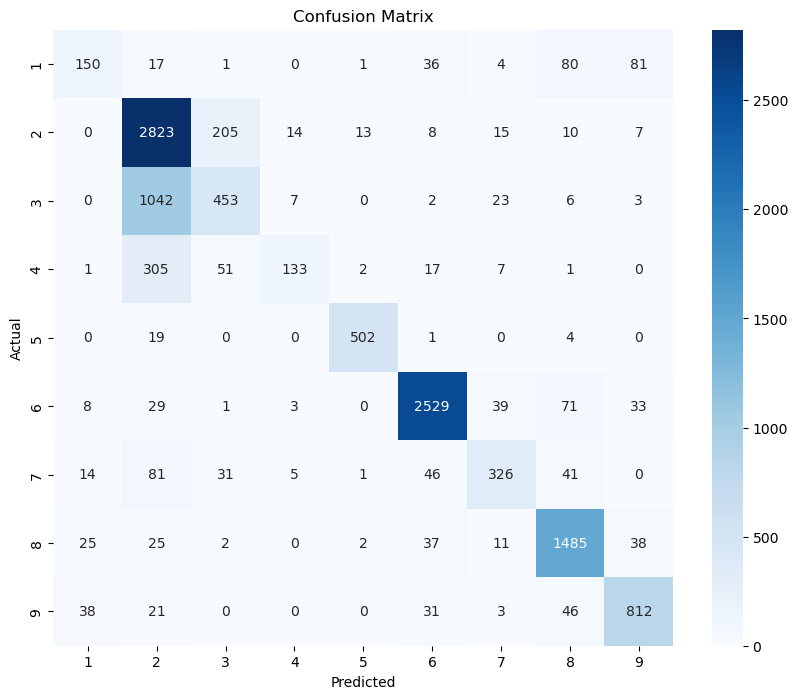

Train Accuracy: 0.79842
Test Accuracy: 0.7756356288937531
Classification Report:
               precision    recall  f1-score   support

           1       0.64      0.41      0.50       370
           2       0.65      0.91      0.76      3095
           3       0.61      0.29      0.40      1536
           4       0.82      0.26      0.39       517
           5       0.96      0.95      0.96       526
           6       0.93      0.93      0.93      2713
           7       0.76      0.60      0.67       545
           8       0.85      0.91      0.88      1625
           9       0.83      0.85      0.84       951

    accuracy                           0.78     11878
   macro avg       0.78      0.68      0.70     11878
weighted avg       0.78      0.78      0.76     11878

Accuracy: 0.7756356288937531


In [17]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Define SVM classifier with default hyperparameters
svm = SVC()

# Fit SVM classifier on training data
svm.fit(X_train_pca, y_train)

# Predict labels for test data
y_pred = svm.predict(X_test_pca)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train accuracy
train_accuracy = svm.score(X_train_pca, y_train)
print("Train Accuracy:", train_accuracy)

# Test accuracy
test_accuracy = svm.score(X_test_pca, y_test)
print("Test Accuracy:", test_accuracy)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

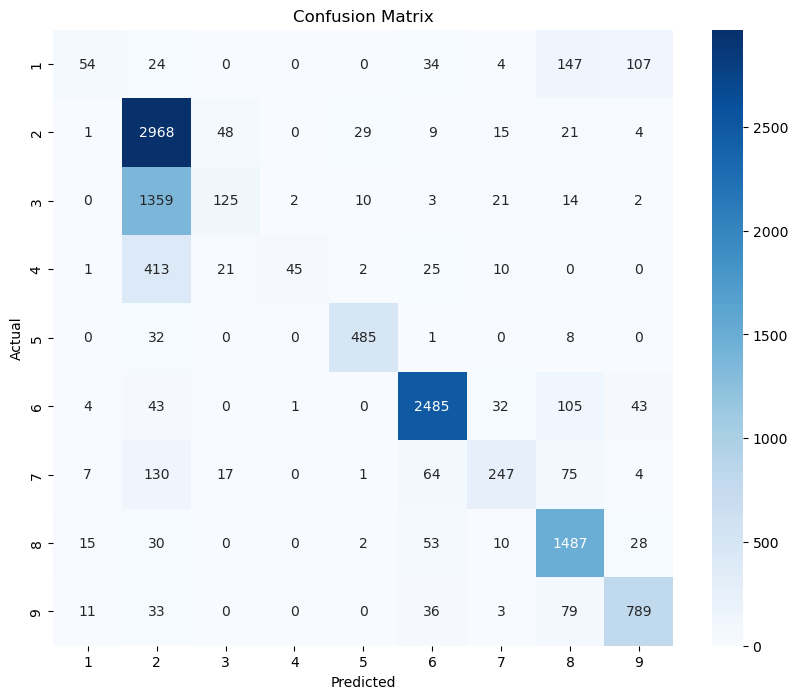

Accuracy: 0.7311837009597575
Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.15      0.23       370
           2       0.59      0.96      0.73      3095
           3       0.59      0.08      0.14      1536
           4       0.94      0.09      0.16       517
           5       0.92      0.92      0.92       526
           6       0.92      0.92      0.92      2713
           7       0.72      0.45      0.56       545
           8       0.77      0.92      0.84      1625
           9       0.81      0.83      0.82       951

    accuracy                           0.73     11878
   macro avg       0.76      0.59      0.59     11878
weighted avg       0.74      0.73      0.68     11878



In [18]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

class SVM_classifier():
    def __init__(self, kernel='linear', C=1.0):
        self.kernel = kernel
        self.C = C
        self.svm = SVC(kernel=kernel, C=C)

    def fit(self, X, y):
        self.svm.fit(X, y)

    def predict(self, X):
        return self.svm.predict(X)

# Instantiate SVM_classifier
svm = SVM_classifier(kernel='linear', C=1.0)

# Fit the model to training data
svm.fit(X_train_pca, y_train)

# Predict labels for test data
y_pred = svm.predict(X_test_pca)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
#print("Confusion Matrix:\n", cm)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

### Logistic Regression

Cross-validation scores: [0.7252 0.7316 0.7309 0.7322 0.7265]
Mean CV Score: 0.72928

Accuracy of Logistic Regression model on Training Data: 0.73292

Accuracy of Logistic Regression model on Test Data: 0.7313520794746591

Classification Report for Logistic Regression on Test Data:
               precision    recall  f1-score   support

           1       0.59      0.14      0.22       370
           2       0.60      0.91      0.73      3095
           3       0.54      0.21      0.30      1536
           4       0.89      0.12      0.21       517
           5       0.90      0.91      0.91       526
           6       0.90      0.92      0.91      2713
           7       0.72      0.42      0.53       545
           8       0.78      0.90      0.83      1625
           9       0.80      0.81      0.81       951

    accuracy                           0.73     11878
   macro avg       0.75      0.59      0.61     11878
weighted avg       0.73      0.73      0.69     11878



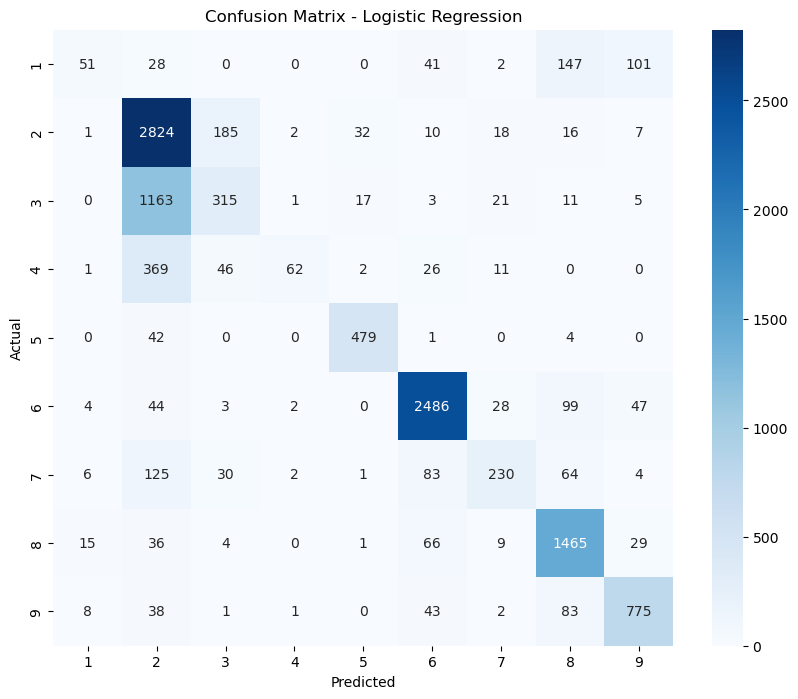

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create Logistic Regression model
logistic_model_cv = LogisticRegression(max_iter=1000)

# Perform cross-validation and get scores
cv_scores = cross_val_score(logistic_model_cv, X_train_pca, y_train, cv=5)  # 5-fold cross-validation
print("Cross-validation scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Fit the model on the full training data
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_pca, y_train)

# Predict on the test data
y_pred_logistic = logistic_model.predict(X_test_pca)

# Evaluate the model on training data
y_pred_train_logistic = logistic_model.predict(X_train_pca)
train_accuracy_logistic = accuracy_score(y_train, y_pred_train_logistic)
print("\nAccuracy of Logistic Regression model on Training Data:", train_accuracy_logistic)

# Evaluate the model on test data
y_pred_logistic = logistic_model.predict(X_test_pca)
test_accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("\nAccuracy of Logistic Regression model on Test Data:", test_accuracy_logistic)

# Classification Report on Test Data
logistic_report = classification_report(y_test, y_pred_logistic)
print("\nClassification Report for Logistic Regression on Test Data:\n", logistic_report)

# Confusion Matrix and Heatmap on Test Data
logistic_cm = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(10, 8))
sns.heatmap(logistic_cm, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Logistic Regression - Iterating Over L1_Ratio Values (ElasticNet Regularization)

In [25]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Setup
l1_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results = []

for l1 in l1_ratios:
    logistic_model_cv = LogisticRegression(max_iter=10000, penalty='elasticnet', l1_ratio=l1, solver='saga')
    cv_scores = cross_val_score(logistic_model_cv, X_train_pca, y_train, cv=5)
    mean_cv_score = cv_scores.mean()
    
    logistic_model_cv.fit(X_train_pca, y_train)
    y_pred_train = logistic_model_cv.predict(X_train_pca)
    y_pred_test = logistic_model_cv.predict(X_test_pca)
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    report = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    
    results.append({
        'l1_ratio': l1,
        'Mean CV Score': mean_cv_score,
        'Training Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Macro Avg F1-Score': report['macro avg']['f1-score'],
        'Weighted Avg F1-Score': report['weighted avg']['f1-score']
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 l1_ratio  Mean CV Score  Training Accuracy  Test Accuracy  Macro Avg F1-Score  Weighted Avg F1-Score
      0.0        0.72926            0.73296       0.731352            0.605151               0.694887
      0.1        0.73002            0.73344       0.731857            0.606345               0.695947
      0.2        0.73074            0.73412       0.733120            0.610545               0.698122
      0.3        0.73168            0.73524       0.734299            0.613943               0.699941
      0.4        0.73264            0.73616       0.735225            0.617194               0.701564
      0.5        0.73370            0.73732       0.735477            0.618925               0.702403
      0.6        0.73502            0.73852       0.736151            0.622313               0.703954
      0.7        0.73654            0.74022       0.738003            0.626653               0.706805
      0.8        0.73844            0.74230       0.739097            0.630972    

### Logistic Regression - Iterating Over 'C' Values (ElasticNet Regularization)

In [24]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Setup
C_values = [0.01, 0.1, 1, 10, 100]
results = []

for c in C_values:
    logistic_model_cv = LogisticRegression(max_iter=10000, penalty='elasticnet', l1_ratio=0.75, solver='saga', C=c)
    cv_scores = cross_val_score(logistic_model_cv, X_train_pca, y_train, cv=5)
    mean_cv_score = cv_scores.mean()
    
    logistic_model_cv.fit(X_train_pca, y_train)
    y_pred_train = logistic_model_cv.predict(X_train_pca)
    y_pred_test = logistic_model_cv.predict(X_test_pca)
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    report = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    
    results.append({
        'C value': c,
        'Mean CV Score': mean_cv_score,
        'Training Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Macro Avg F1-Score': report['macro avg']['f1-score'],
        'Weighted Avg F1-Score': report['weighted avg']['f1-score']
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 C value  Mean CV Score  Training Accuracy  Test Accuracy  Macro Avg F1-Score  Weighted Avg F1-Score
    0.01        0.57202            0.59228       0.588735            0.302766               0.496139
    0.10        0.70438            0.70950       0.704412            0.531954               0.653586
    1.00        0.73732            0.74134       0.738929            0.629036               0.708220
   10.00        0.74814            0.75138       0.749200            0.664612               0.726079
  100.00        0.75016            0.75366       0.751052            0.670276               0.729117


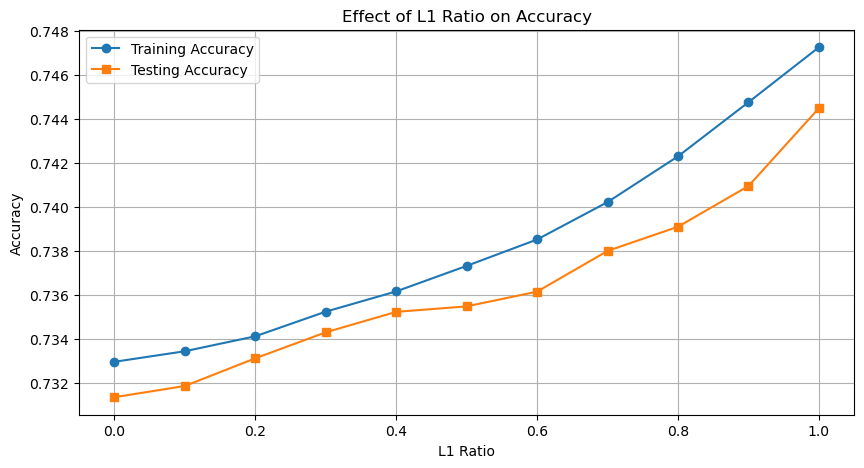

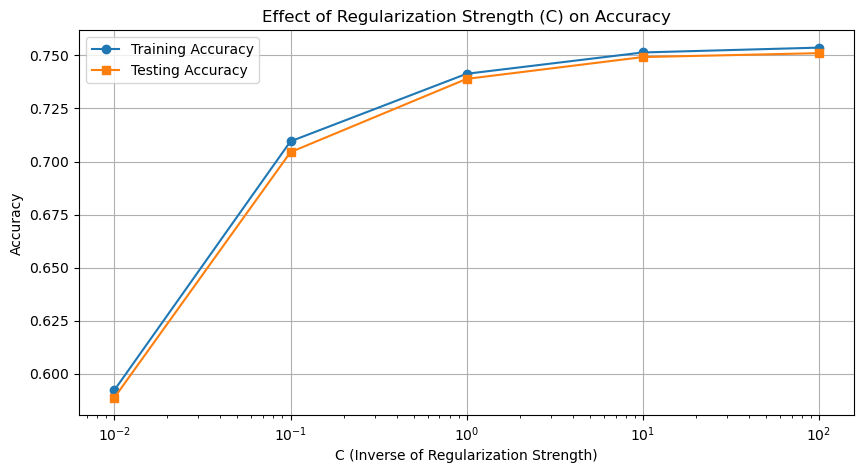

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# L1 Ratio Accuracies
l1_ratios = np.linspace(0, 1, 11)  # Assuming you have 11 evenly spaced L1 ratios from 0 to 1
l1_train_accuracies = [0.73296, 0.73344, 0.73412, 0.73524, 0.73616, 0.73732, 0.73852, 0.74022, 0.74230, 0.74476, 0.74726]
l1_test_accuracies = [0.73135, 0.73186, 0.73312, 0.73430, 0.73523, 0.73548, 0.73615, 0.73800, 0.73910, 0.74095, 0.74449]

# Plot L1 Ratio Accuracies
plt.figure(figsize=(10, 5))
plt.plot(l1_ratios, l1_train_accuracies, marker='o', label='Training Accuracy')
plt.plot(l1_ratios, l1_test_accuracies, marker='s', label='Testing Accuracy')
plt.title('Effect of L1 Ratio on Accuracy')
plt.xlabel('L1 Ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# C Values Accuracies
C_values = np.logspace(-2, 2, 5)  # Corrected to match the provided C values
C_train_accuracies = [0.59228, 0.70950, 0.74134, 0.75138, 0.75366]
C_test_accuracies = [0.58874, 0.70441, 0.73893, 0.74920, 0.75105]

# Plot C Value Accuracies
plt.figure(figsize=(10, 5))
plt.semilogx(C_values, C_train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, C_test_accuracies, marker='s', label='Testing Accuracy')
plt.title('Effect of Regularization Strength (C) on Accuracy')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
